# Recursive QAOA

In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [73]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [74]:
def run_Rqaoa_experiment(qubo, optimizer, init_beta, init_gamma):  
    
    # Define the RQAOA object (default rqaoa_type = 'adaptive')
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    R.set_rqaoa_parameters(steps = 1, n_cutoff=3)

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    #R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[0.01], "gammas":[0.01]}, mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    # Here are other ways in which the above selection can be generalized!

    # device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
    # r.set_device(device)
    # r.set_backend_properties(n_shots=100, cvar_alpha=1)
    # r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
    # r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)
    

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    return R.results


In [75]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [76]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

Sigma = 10
Seed = 1
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


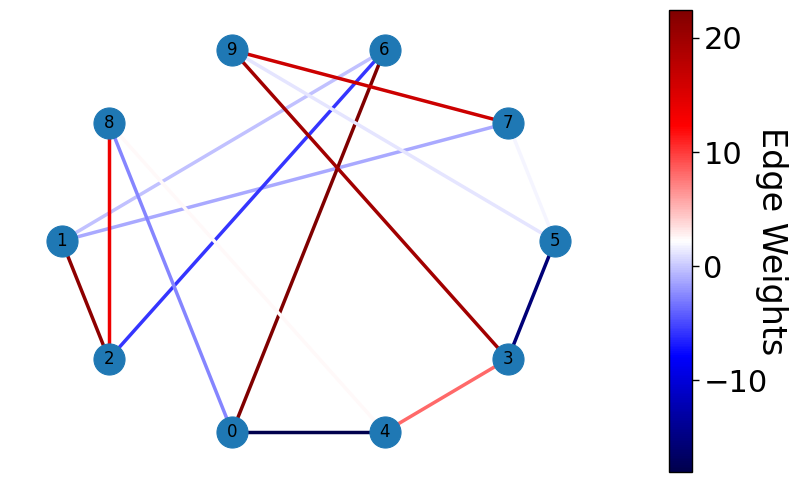

In [20]:
# Define problem

n = 10
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


optimizer_list = ["nelder-mead"]
sigma_list = [10]

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1]

data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

In [21]:
df

,sigma,optimizer,seed,r
0,10.0,nelder-mead,1,1.0


In [22]:
opt_results

{'solution': {'1011000011': -138.9314122098009,
  '0100111100': -138.9314122098009},
 'classical_output': {'minimum_energy': -12.62656828672251,
  'optimal_states': ['110', '001']},
 'elimination_rules': [{(0, 1): -1.0},
  {(1, 6): -1.0},
  {(1, 2): 1.0},
  {(0, 6): 1.0},
  {(4, 5): -1.0},
  {(2, 4): 1.0},
  {(2, 3): 1.0}],
 'schedule': [1, 1, 1, 1, 1, 1, 1],
 'intermediate_steps': [{'QUBO': <openqaoa.problems.problem.QUBO at 0x7f70af407b50>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f70af407ca0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f70af406410>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f70af406350>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f70af453f40>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f70af453dc0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f70af4f3700>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f70af4f3820>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f70af33ad40>,
   'QAOA': <openqaoa.workflows.op

In [23]:
intermediate_steps = len(opt_results['intermediate_steps'])
intermediate_steps

7

Graph with 9 nodes and 13 edges
Graph with 8 nodes and 12 edges
Graph with 7 nodes and 10 edges
Graph with 6 nodes and 8 edges
Graph with 5 nodes and 6 edges
Graph with 4 nodes and 4 edges
Graph with 3 nodes and 3 edges


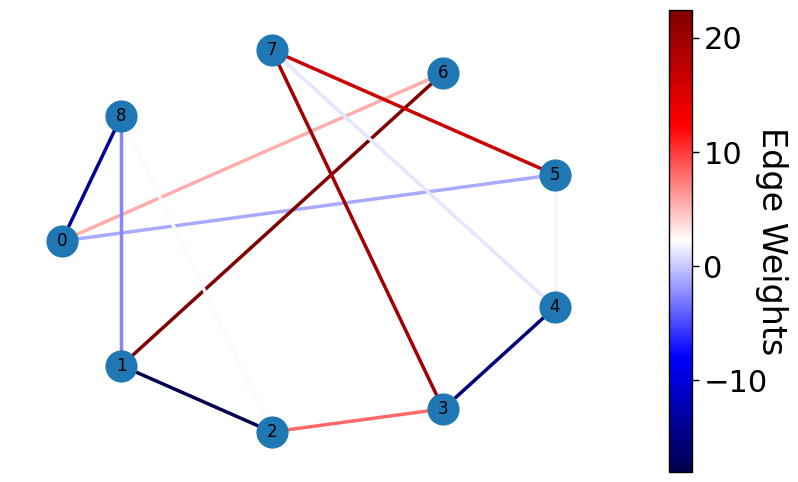

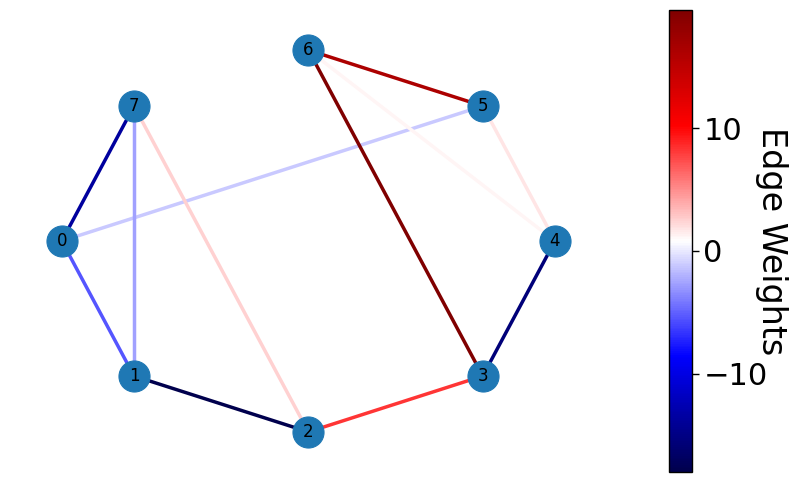

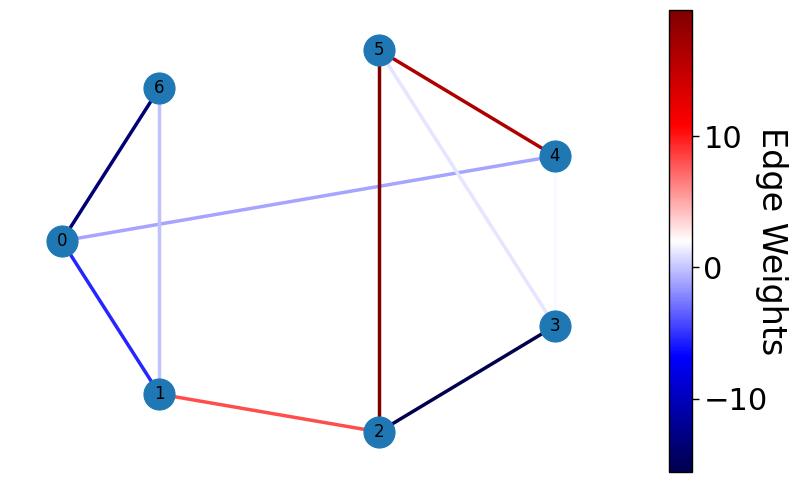

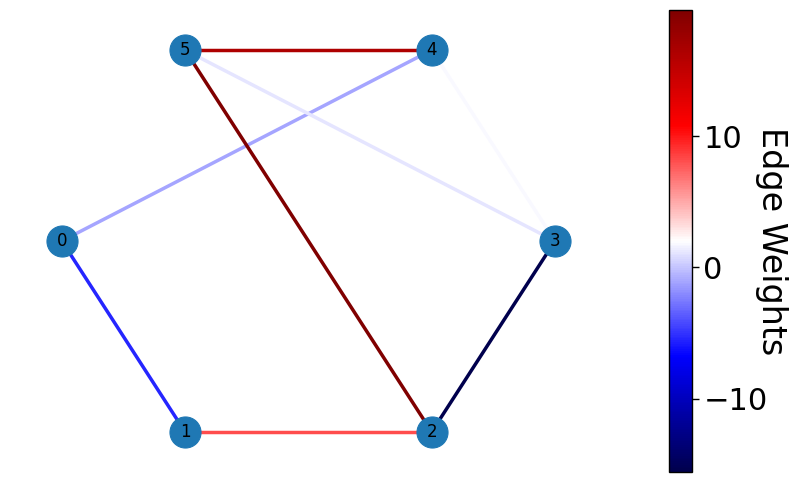

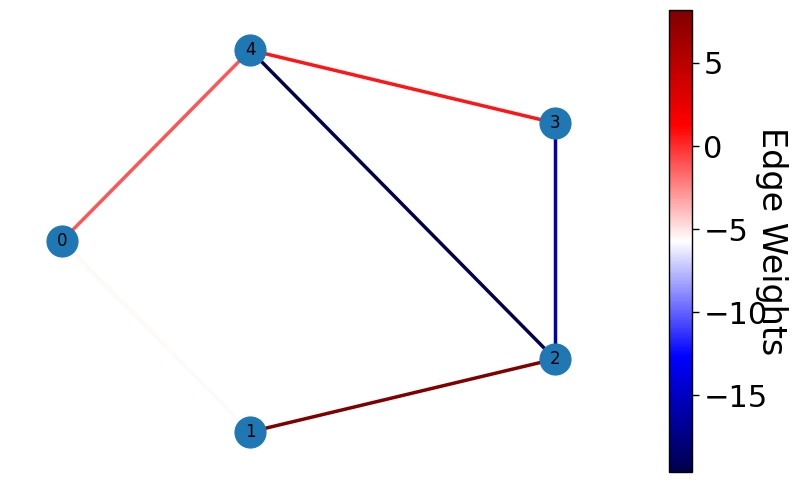

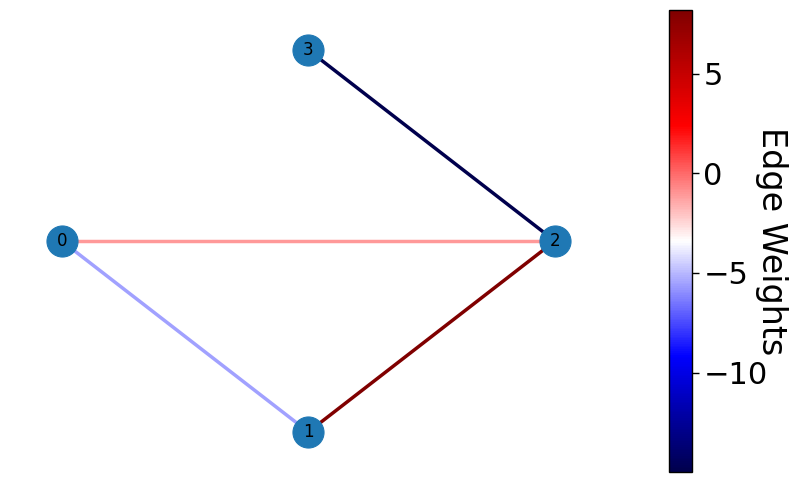

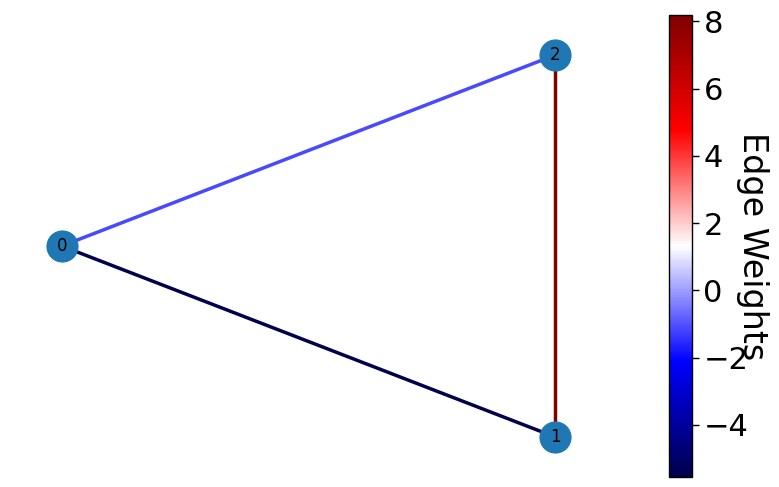

In [24]:
for i in range(0, intermediate_steps):
    intermediate_qubo = opt_results['intermediate_steps'][i]['QUBO']
    intermediate_hamiltonian = intermediate_qubo.hamiltonian
    intermediate_g = graph_from_hamiltonian(intermediate_hamiltonian)
    print(intermediate_g)
    plot_graph(intermediate_g)

In [25]:
opt_results['intermediate_exp_vals_z']

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.])]

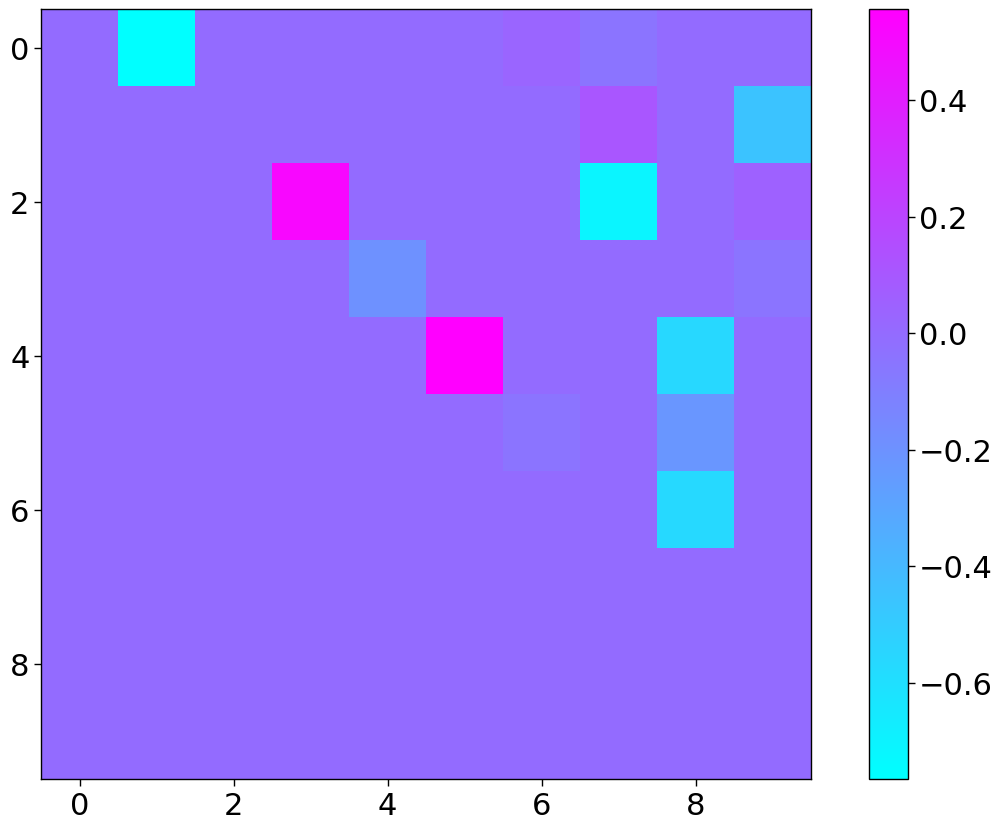

In [26]:
plt.imshow(opt_results['intermediate_corr_matrix'][0], cmap="cool")
plt.colorbar()

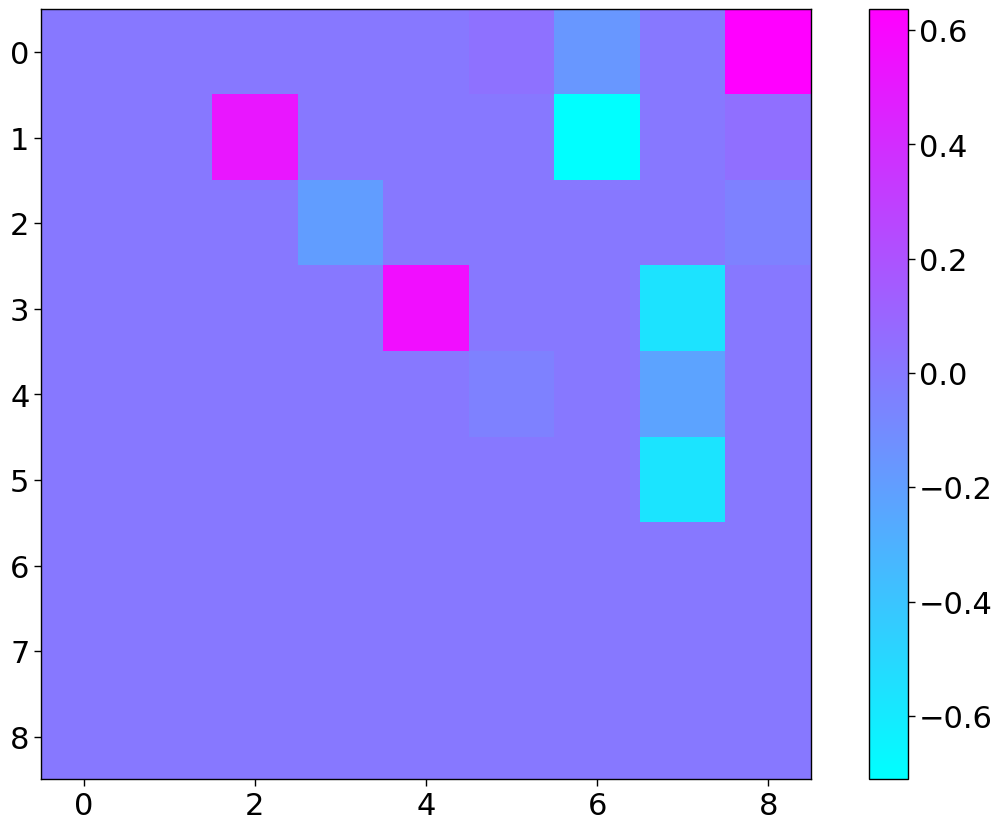

In [27]:
plt.imshow(opt_results['intermediate_corr_matrix'][1], cmap="cool")
plt.colorbar()

Graph with 9 nodes and 13 edges


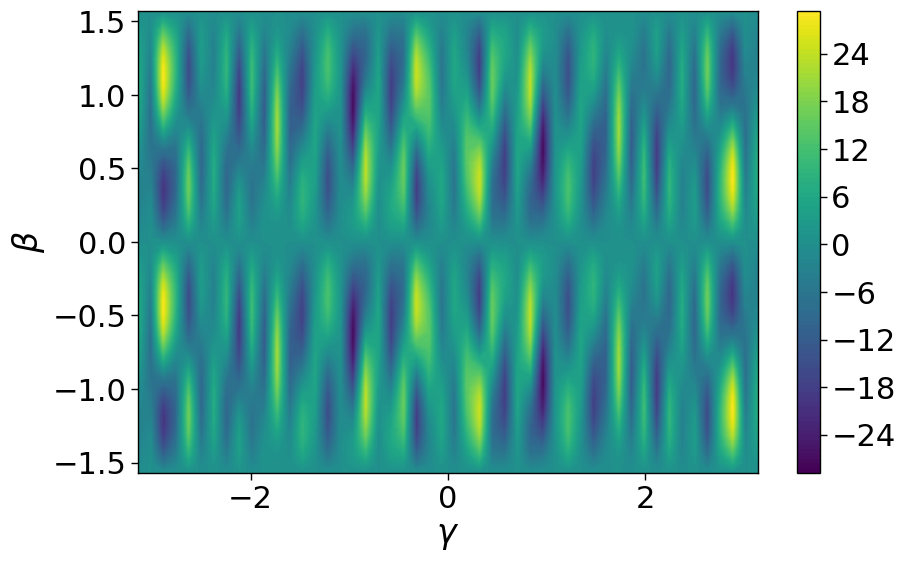

Graph with 8 nodes and 12 edges


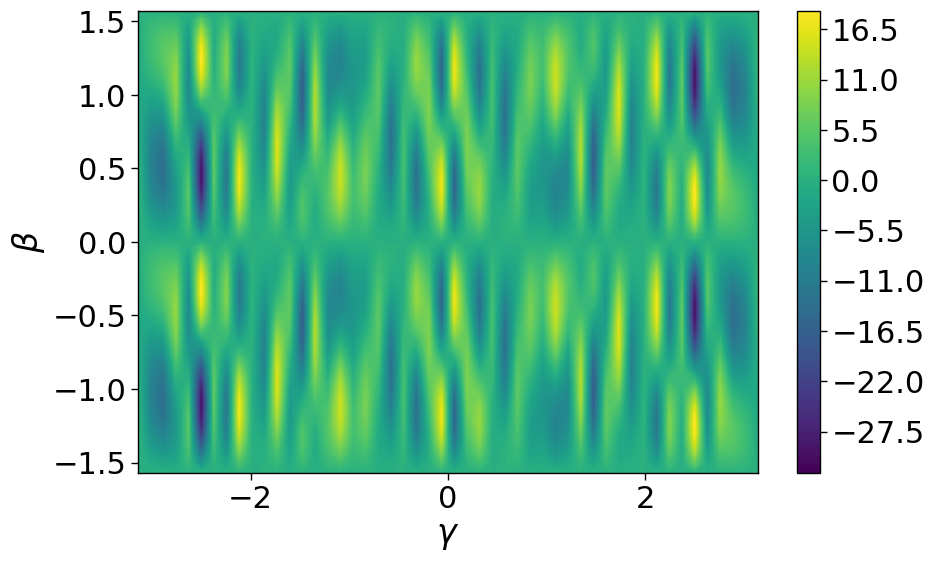

Graph with 7 nodes and 10 edges


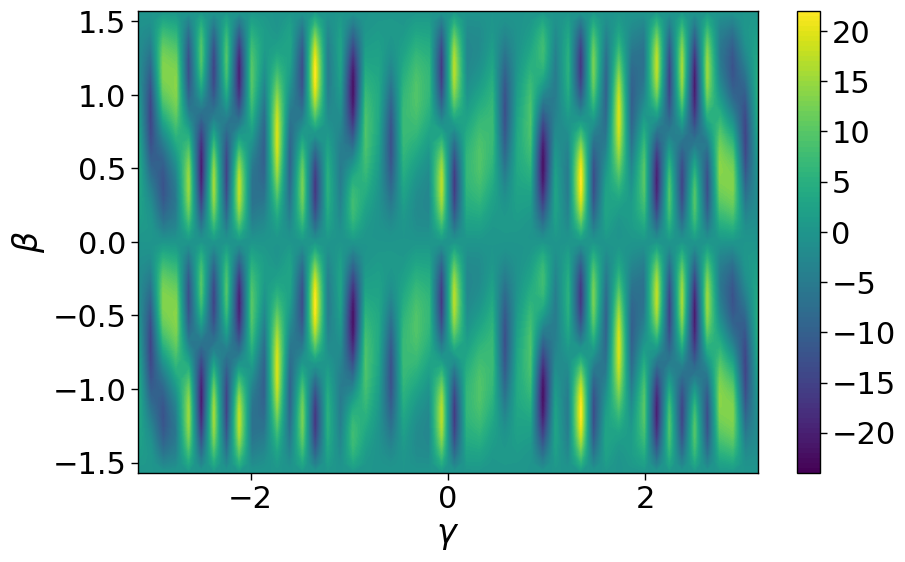

Graph with 6 nodes and 8 edges


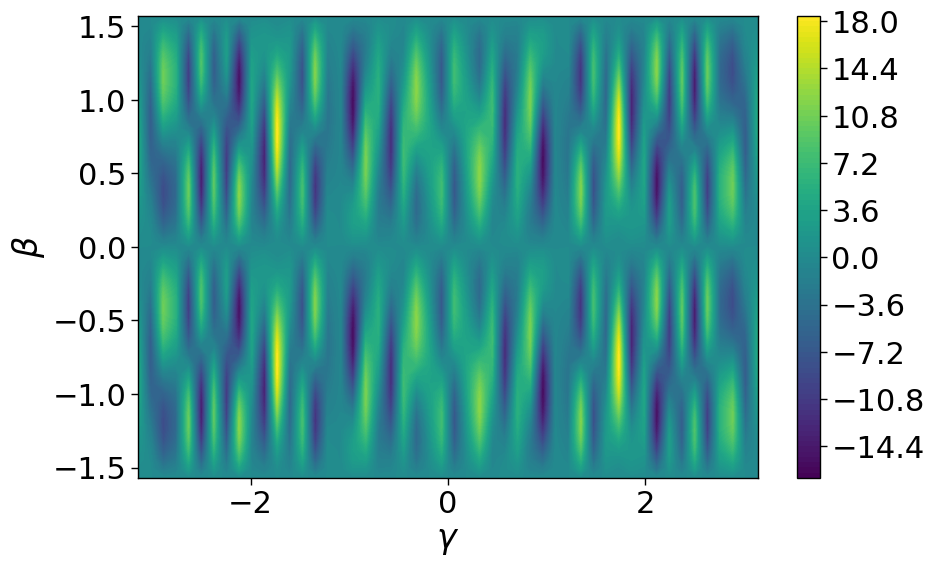

Graph with 5 nodes and 6 edges


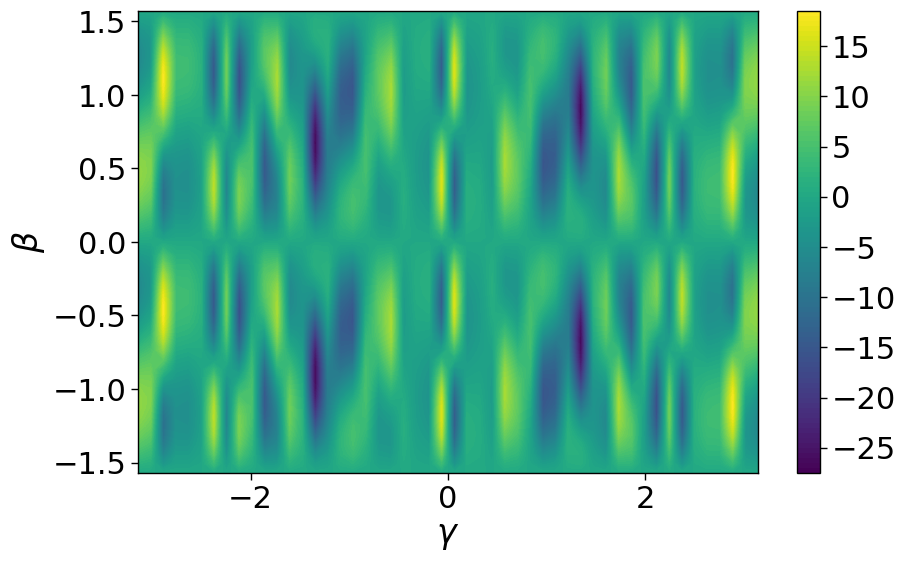

Graph with 4 nodes and 4 edges


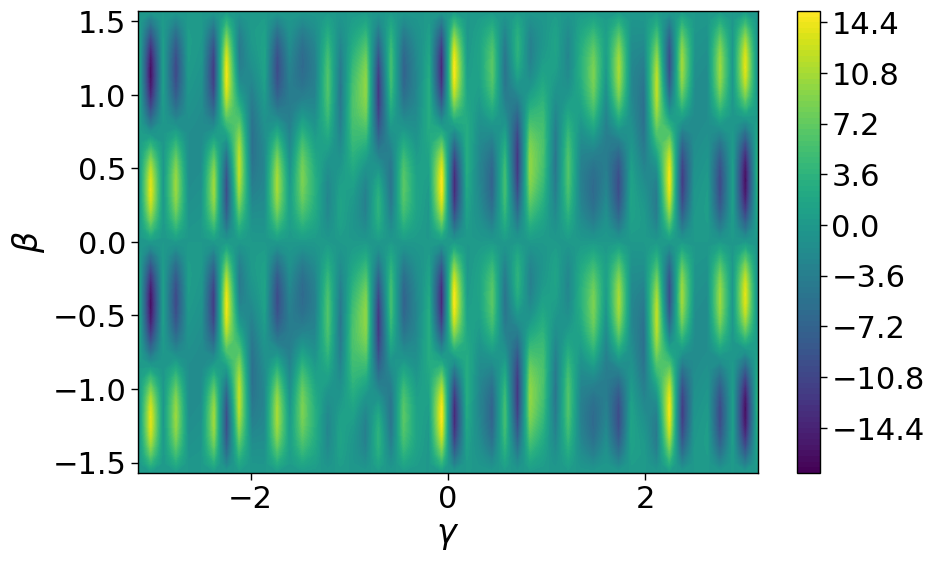

Graph with 3 nodes and 3 edges


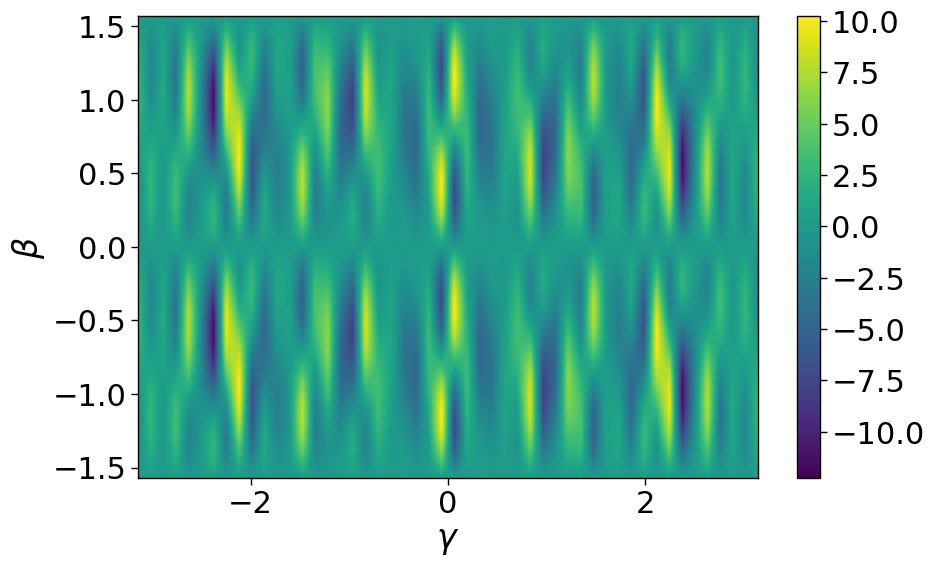

In [28]:
for i in range(0, intermediate_steps):
    intermediate_qubo = opt_results['intermediate_steps'][i]['QUBO']
    intermediate_hamiltonian = intermediate_qubo.hamiltonian
    intermediate_g = graph_from_hamiltonian(intermediate_hamiltonian)
    print(intermediate_g)
    plot_graph(intermediate_g)
    plt.clf()
    cost_landscape = create_cost_landscape_std(intermediate_hamiltonian, betas, gammas)
    plot_landscape(cost_landscape, betas, gammas, sigma, mu)


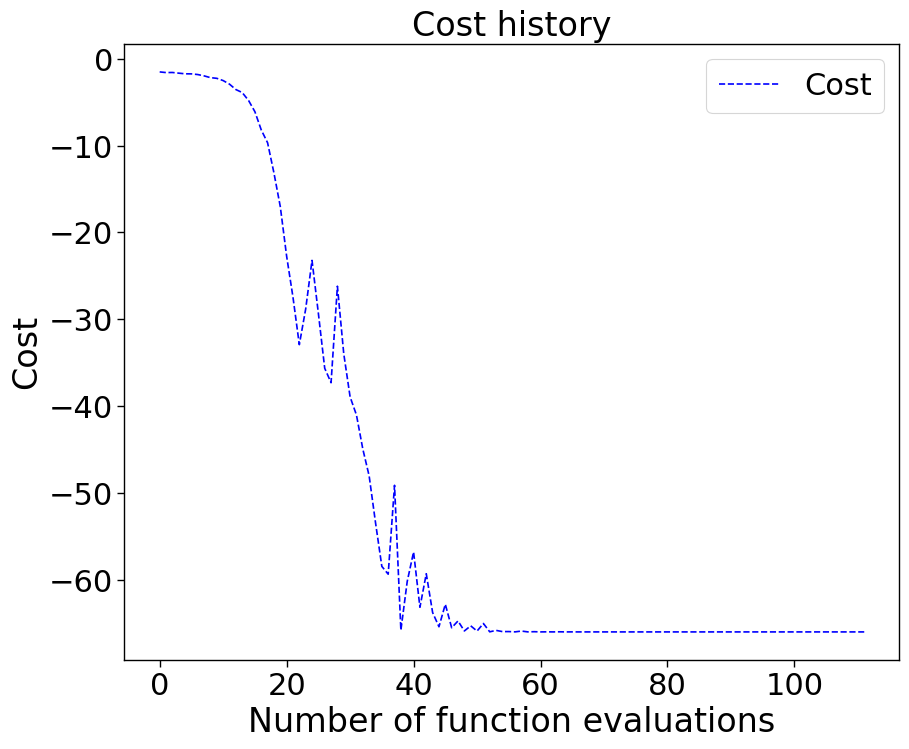

In [29]:
intermediate_qaoa = opt_results['intermediate_steps'][1]['QAOA']
intermediate_qaoa.results.plot_cost()

### Averaging over Optimizers

In [64]:
# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop", 'newton-cg', 'cobyla', 'nelder-mead']

seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

#data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)  # be very careful here which initialization is given inside the function

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

Sigma = 0.1
Seed = 1
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 2
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 3
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 4
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 5
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 6
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 7
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 8
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 9
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 10
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 11
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 12
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 13
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 14
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 15
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 16
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 17
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 18
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 19
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 20
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 21
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 22
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 23
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 24
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 25
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 30
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 31
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 32
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 33
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 34
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 35
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 36
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 37
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 38
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 39
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 40
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 41
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 42
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 43
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 44
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 45
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 46
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 47
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 48
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 49
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 50
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 51
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 52
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 53
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 54
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 55
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 56
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 57
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 58
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 59
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 60
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 61
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 62
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 63
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 64
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 65
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 66
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 67
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 68
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 69
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 70
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 71
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 72
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 73
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 74
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 75
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 76
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 77
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 78
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 79
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 80
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 81
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 82
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 83
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 84
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 85
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 86
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 87
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 88
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 89
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 90
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 91
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 92
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 93
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 94
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 95
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 96
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 97
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 98
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 99
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 100
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Sigma = 1
Seed = 1
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 2
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 3
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 4
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 5
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 6
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 7
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 8
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 9
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 10
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 11
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 12
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 13
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 14
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 15
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 16
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 17
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 18
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 19
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 20
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 21
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 22
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 23
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 24
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 25
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 26
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 27
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 28
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 29
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 30
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 31
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 32
Optimizer = rmsprop
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 34
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 35
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 36
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 37
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 38
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 39
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 40
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 41
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 42
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 43
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 44
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 45
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 46
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 47
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 48
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 49
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 50
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 51
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 52
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 53
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 54
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 55
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 56
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 57
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 58
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 59
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 60
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 61
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 62
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 63
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 64
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 65
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 66
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 67
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 68
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 69
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 70
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 71
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 72
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 73
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 74
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 75
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 76
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 77
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 78
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 79
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 80
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 81
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 82
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 83
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 84
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 85
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 86
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 87
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 88
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 89
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 90
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 91
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 36
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 37
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 38
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 39
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 40
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 41
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 42
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 43
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 44
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 45
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 46
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 47
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 48
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 49
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 50
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 51
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 52
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 53
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 54
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 55
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 56
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 57
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 58
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 59
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 60
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 61
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 62
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 63
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 64
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 65
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 66
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 67
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 68
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 69
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 70
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 71
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 72
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 73
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 74
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 75
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 76
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 77
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 78
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 79
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 80
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 81
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 82
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 83
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 84
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 85
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsi

Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 86
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 87
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 88
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 89
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeW

Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 90
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 91
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 92
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 93
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 94
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 95
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 96
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 97
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 98
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 99
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 100
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Sigma = 100
Seed = 1
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 2
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 3
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 4
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 7
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 9
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 10
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 12
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 13
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 14
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 15
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 16
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 17
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 18
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 19
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 20
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 21
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 22
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 23
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 24
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 25
Optimizer = rmsprop
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 26
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 27
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 28
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 29
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 30
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 31
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 32
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 33
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 34
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 35
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 36
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 37
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 38
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 39
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 40
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 41
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 42
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 43
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 44
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 45
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 46
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 47
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 48
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 49
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 50
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 51
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 52
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 53
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 54
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 55
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 56
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 57
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 58
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 59
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 60
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla
Optimizer = nelder-mead
Seed = 61
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 62
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 64
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 65
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 66
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 67
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 68
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 69
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 70
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 71
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 72
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 73
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 74
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 75
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 76
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 77
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 78
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 79
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 80
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 81
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 82
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 83
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 84
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 85
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 86
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 87
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 88
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 89
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 90
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 91
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 92
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 93
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 94
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = cobyla
Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 95
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 96
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla
Optimizer = nelder-mead
Seed = 97
Optimizer = rmsprop
Optimizer = newton-cg
Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 98
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 99
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 100
Optimizer = rmsprop
Optimizer = newton-cg


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,
/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:462: OptimizeWarning: Unknown solver options: stepsize, maxfev
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Optimizer = cobyla


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimizer = nelder-mead


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


In [69]:
df.to_csv("data_23.11_RQAOA_seeds_100_ramp_optimizers.csv")

In [53]:
#df = pd.read_csv('data_22.11_RQAOA_seeds_100_optimizers.csv', index_col=0)

In [77]:
df

,sigma,optimizer,seed,r
0,10.0,nelder-mead,1,1.000000
1,0.1,powell,1,1.000000
2,0.1,powell,2,1.000000
3,1.0,powell,1,1.000000
4,1.0,powell,2,1.000000
...,...,...,...,...
1614,100.0,nelder-mead,99,0.887916
1615,100.0,rmsprop,100,0.816676
1616,100.0,newton-cg,100,1.000000
1617,100.0,cobyla,100,0.972574


In [84]:
to_be_removed = df.loc[df.optimizer == 'powell', ['sigma', 'seed', 'r']]

In [85]:
bad_indexes = df.reset_index().merge(to_be_removed)['index']

In [88]:
df = df.loc[~df.index.isin(bad_indexes)]

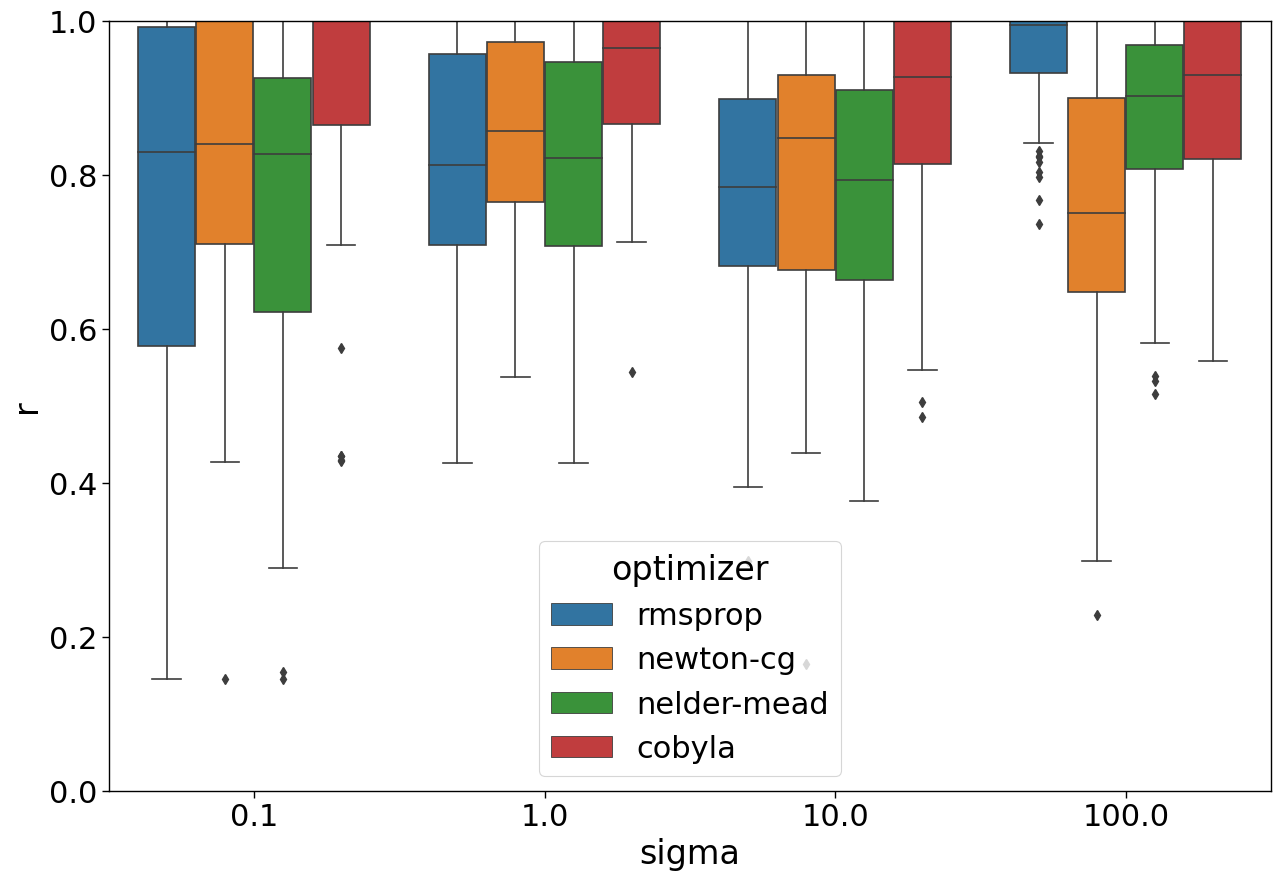

In [90]:
#plt.xscale('log')
plt.ylim(0, 1)
box_plot = sns.boxplot(data = df, x = 'sigma', y ='r', hue="optimizer")

plt.savefig("Approximation_ratio_mu=5.0_RQAOA_ramp_optimizers_NEW.png")


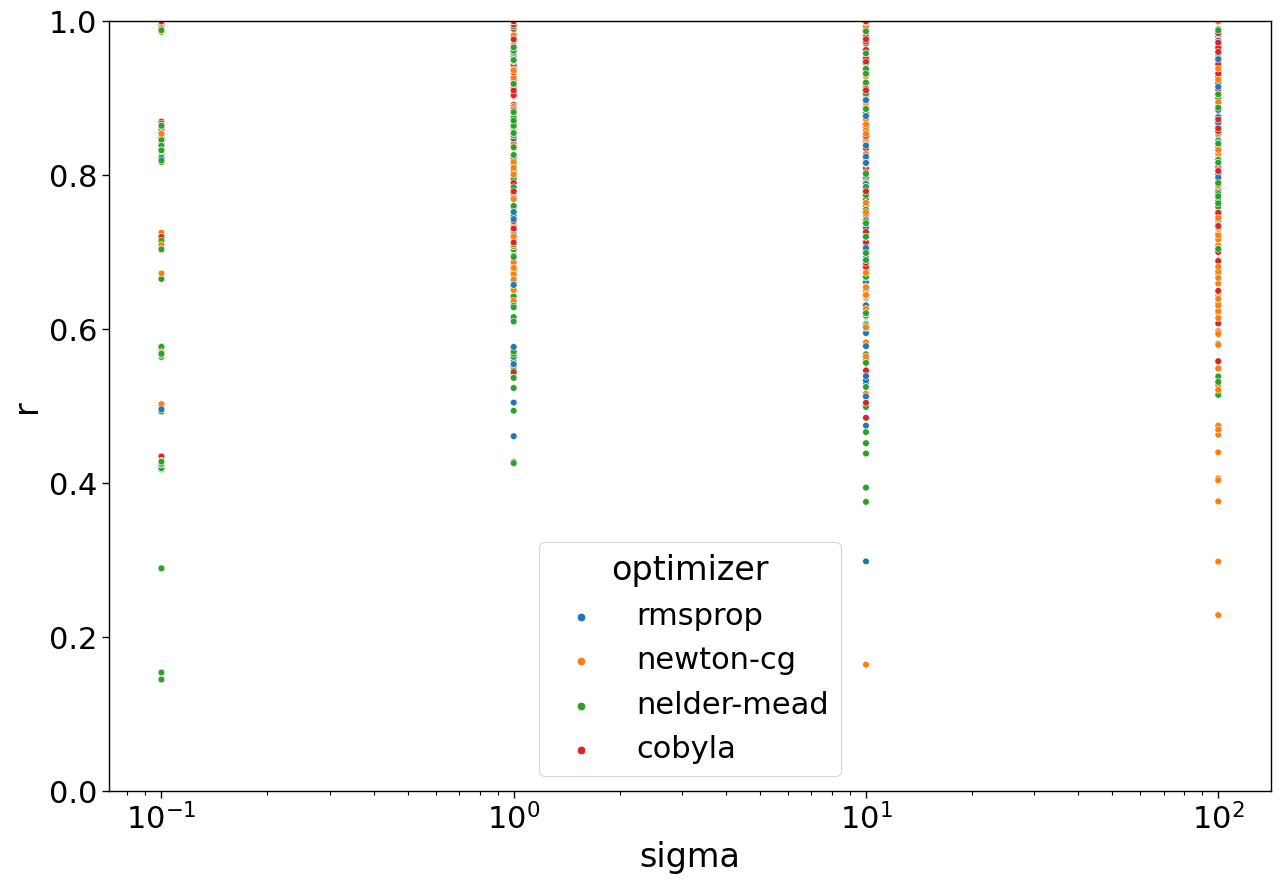

In [91]:
plt.xscale('log')
plt.ylim(0, 1)
sns.scatterplot(data = df, x = 'sigma', y ='r', hue="optimizer")

plt.savefig("Approximation_ratio_mu=5.0_RQAOA_ramp_optimizers_scatterplot_NEW.png")


### Time the perfomance of each optimizer

In [63]:
%%time

# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop"]

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [26]
sigma_list = [1]

#data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)


            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])
            

'''
df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)
'''

Sigma = 1
Seed = 26
Optimizer = rmsprop
CPU times: user 9.62 s, sys: 3.97 ms, total: 9.62 s
Wall time: 9.62 s


"\ndf = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])\n\ndf['sigma'] = df['sigma'].astype(float)\ndf['optimizer'] = df['optimizer'].astype(str)\ndf['seed'] = df['seed'].astype(int)\ndf['r'] = df['r'].astype(float)\n"

In [40]:
data_time=[]

data_time.append(['rmsprop', 72.0])
data_time.append(['cobyla', 15.3])
data_time.append(['powell', 1.04])
data_time.append(['nelder-mead', 1.02])
print(data_time)
df_time = pd.DataFrame(np.array(data_time), columns=['optimizer', 'time'])


df_time['optimizer'] = df_time['optimizer'].astype(str)
df_time['time'] = df_time['time'].astype(float)  # in seconds

[['rmsprop', 72.0], ['cobyla', 15.3], ['powell', 1.04], ['nelder-mead', 1.02]]


In [41]:
df_time

,optimizer,time
0,rmsprop,72.00
1,cobyla,15.30
2,powell,1.04
3,nelder-mead,1.02


## Averaging over initializations

In [ ]:
# Define problem

n = 12
k = 3
sigma_list = [100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ['nelder-mead']

seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1, 2]

#data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("graph_seed=", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)
        
        # Solve the problem analytically
        energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)
            
            r_best = 0.5
            r_all = []

            # initialize randomly
            for init_seed in [10, 20, 30]:
                random.seed(init_seed)
                init_beta = random.uniform(0, np.pi/2)
                init_gamma = random.uniform(0, 5*np.pi)
                
                print(init_beta)
                print(init_gamma)

                opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

                optimization_energy = list(opt_results['solution'].values())[0]

                # Obtain approximation ratio
                r = np.abs(optimization_energy) / np.abs(energy)
                r_all.append()
                
                if r > r_best:
                    r_best = r
                    
            r_avr = np.average(r_all)

            data.append([sigma, optimizer, seed, r_best, r_avr])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r_best', 'r_avr'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

In [66]:
a = [1, 0.3, 4]